# Particle Cloud Simulation Example

In this example we simulate the trajectory of a particle cloud in a randomly generated flow field, in a doubly periodic domain. As an exercise left to the user, directions are provided e.g. to modify the size of the domain or the rate of divergence within the particle cloud. 

- 1. setup the software and initialize example
- 2. simulate trajectories & plot results
- 3. experiment with parameters (user)

### For More Documentation 

- <https://docs.juliadiffeq.org/latest> 
- <https://en.wikipedia.org/wiki/Displacement_(vector)>
- <https://juliaclimate.github.io/IndividualDisplacements.jl/dev>
- <https://juliaclimate.github.io/MeshArrays.jl/dev>

## 1.1 Import Software

In [1]:
using OrdinaryDiffEq, Plots, ColorSchemes, Statistics, Random
using IndividualDisplacements, MeshArrays, DataFrames
p=dirname(pathof(MeshArrays)); include(joinpath(p,"../examples/Demos.jl"))

demo3 (generic function with 2 methods)

## 1.2 Setup Problem

Put grid variables in a dictionary.

In [2]:
np=24

function SetupPeriodicDomain(np::Integer=16)
    γ,Γ=GridOfOnes("PeriodicDomain",1,np)
    Γ["XC"][1]=vec(0.5:1.0:np-0.5)*ones(1,np)
    Γ["XG"][1]=vec(0.0:1.0:np-1.0)*ones(1,np)
    Γ["YC"][1]=ones(np,1)*transpose(vec(0.5:1.0:np-0.5))
    Γ["YG"][1]=ones(np,1)*transpose(vec(0.0:1.0:np-1.0))
    return γ,Γ
end

γ,Γ=SetupPeriodicDomain(np);

Derive flow field from randomly generated ϕ streamfunction

In [3]:
(_,ϕ,_,_)=demo2(Γ);

(u,v)=gradient(ϕ,Γ)
u=u./Γ["DXC"]#normalization to grid units
v=v./Γ["DYC"]
(u,v)=exchange(u,v,1)
u0=-v; u1=-v; 
v0=u; v1=u;

In [4]:
#contourf(vec(Γ["XC"][1][:,1]),vec(Γ["YC"][1][1,:]),transpose(ϕ[1]),linewidth = 0.1,clims=(-0.2,0.2))

Put velocity fields, time parameters, etc in a dictionary.

In [5]:
uvt = Dict( "u0" => u0, "u1" => u1, "v0" => v0, "v1" => v1, 
            "t0" => 0.0, "t1" => 400.0, "dt" => 0.1)

uvetc=merge(uvt,Γ)#add grid variables

msk=Dict("mskW" => fill(1.0,u), "mskS" => fill(1.0,v))
uvetc=merge(uvetc,msk)

Dict{Any,Any} with 25 entries:
  "hFacC" =>   name        = hFacC…
  "t0"    => 0.0
  "RAS"   =>   name        = RAS…
  "YC"    =>   name        = YC…
  "v1"    =>   data type   = Float64…
  "mskW"  =>   data type   = Float64…
  "dt"    => 0.1
  "Depth" =>   name        = Depth…
  "RAC"   =>   name        = RAC…
  "u1"    =>   data type   = Float64…
  "RAZ"   =>   name        = RAZ…
  "XG"    =>   name        = XG…
  "hFacW" =>   name        = hFacW…
  "DYG"   =>   name        = DYG…
  "YG"    =>   name        = YG…
  "RAW"   =>   name        = RAW…
  "u0"    =>   data type   = Float64…
  "hFacS" =>   name        = hFacS…
  "t1"    => 400.0
  "mskS"  =>   data type   = Float64…
  "DXG"   =>   name        = DXG…
  "XC"    =>   name        = XC…
  "DXC"   =>   name        = DXC…
  "DYC"   =>   name        = DYC…
  "v0"    =>   data type   = Float64…

## 1.3 Initial Conditions

In [6]:
ii1=np*collect(0.25:0.02:0.75); ii2=ii1; ii3=[1.0];
#ii1=np*collect(0.1:0.01:0.2); ii2=ii1; ii3=[1.0];
n1=length(ii1); n2=length(ii2); n3=length(ii3);
u0=Array{Float64,2}(undef,(3,n3*n1*n2))
for i1 in eachindex(ii1); for i2 in eachindex(ii2); for i3 in eachindex(ii3);
        i=i1+(i2-1)*n1+(i3-1)*n1*n2
        u0[1,i]=ii1[i1]
        u0[2,i]=ii2[i2]
        u0[3,i]=ii3[i3]
end; end; end;

## 2.1 Compute Trajectories

In [7]:
𝑇 = (0.0,uvetc["t1"]-uvetc["t0"])
prob = ODEProblem(⬡!,u0,𝑇,uvetc)
sol = solve(prob,Tsit5(),reltol=1e-5,abstol=1e-5)
size(sol)

(3, 676, 602)

## 2.2 Process Output For Plotting

In [8]:
#x,y axes etc 
x=sol[1,:,:]
y=sol[2,:,:]
fIndex=sol[3,:,:]
ID=collect(1:size(sol,2))*ones(1,size(sol,3))
df = DataFrame(ID=Int.(ID[:]), x=mod.(x[:],Ref(np)), y=mod.(y[:],Ref(np)), fIndex=fIndex[:]);

In [9]:
#time axis
nf=size(u0,2)
nt=size(df,1)/nf
t=[ceil(i/nf)-1 for i in 1:nt*nf]
df[!,:t]=(uvetc["t1"]-uvetc["t0"])/t[end].*t;

In [10]:
#df

## 2.3 Plot Results

┌ Info: Saved animation to 
│   fn = /var/folders/1m/ddjxkwvn7bz7z9shdnh8q3040000gn/T/RandomFlow.gif
└ @ Plots /Users/gforget/.julia/packages/Plots/cc8wh/src/animation.jl:98


Plots.AnimatedGif("/var/folders/1m/ddjxkwvn7bz7z9shdnh8q3040000gn/T/RandomFlow.gif")
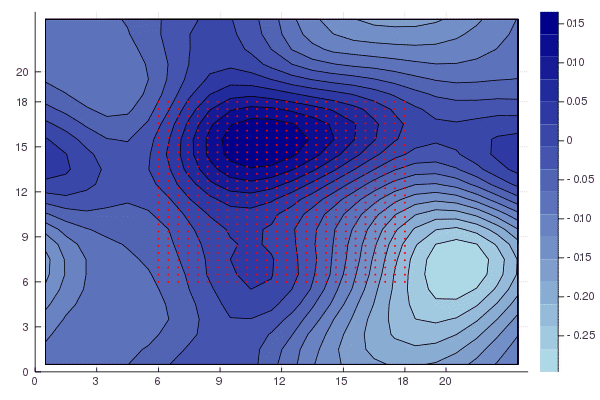

In [11]:
function scatter_subset(df,t)
    dt=5.0
    df_t = df[ (df.t.>t-dt).&(df.t.<=t) , :]
    contourf(vec(Γ["XC"][1][:,1]),vec(Γ["YC"][1][1,:]),transpose(ϕ[1]),c = :blues,linewidth = 0.1)
    #contourf(transpose(ϕ[1]),c = :blues,linewidth = 0.1)
    scatter!(df_t.x,df_t.y,markersize=2.0,c=:red,
    xlims=(0,np),ylims=(0,np),leg=:none,marker = (:circle, stroke(0)))
end

#@gif for t in 0:2.0:maximum(df[!,:t])
#   scatter_subset(df,t)
#end

anim = @animate for t in 0:2.0:maximum(df[!,:t])
   scatter_subset(df,t)
end
pth=tempdir()*"/"
gif(anim, pth*"RandomFlow.gif", fps = 15)